In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import time
from tqdm import tqdm,trange, tqdm_notebook
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import pickle
import scipy.stats
import scipy.io
from scipy.special import comb as nCk

In [2]:
def gain(mu):
    return len(mu)*np.linalg.norm(mu,2)**2/np.linalg.norm(mu,1)**2
f = lambda x :  np.linalg.norm(x)**2

In [3]:
## to examine specific simulation data

baseDir = "pkls/Ax_n100_d100k_pareto/"

myData = pickle.load( open( "{}/info.pkl".format(baseDir), "rb" ) )
numTrials = myData['numTrials']
budgets = myData['budgets']
A = myData['A']
x = myData['x']
(n,d) = A.shape
print(n,d,numTrials)
print(gain(A@x))

100 100000 100
60.50787828051087


In [4]:
## load in optimism based results

errArrOptimism = np.zeros((numTrials,len(budgets)))
pullArrOptimism = np.zeros((numTrials,len(budgets),n))
timingArr = np.zeros(numTrials)

for i in range(numTrials):
    myData = pickle.load( open( "{}/adaOpt_sim{}.pkl".format(baseDir,i), "rb" ) )
    errArrOptimism[i] = myData["errorArr"]
    pullArrOptimism[i] = myData["numPullsArr"]
    timingArr[i] = myData['time']

In [5]:
## load in our batched algorithm results

myData = pickle.load( open( "{}/batchedAlgs.pkl".format(baseDir), "rb" ) )
adaErrorBatch, adaBudgetBatch, adaTimingArr = myData['ada']
unifErrorBatch, unifBudgetBatch, unifTimingArr = myData['unif']

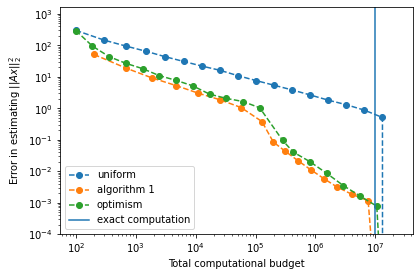

In [6]:
## Plotting error in estimating \|Ax\|_2^2 as in Figure 2

plt.plot(unifBudgetBatch.mean(axis=0),unifErrorBatch.mean(axis=0),'--o',label='uniform')
plt.plot(adaBudgetBatch.mean(axis=0),adaErrorBatch.mean(axis=0),'--o',label='algorithm 1')
plt.plot(pullArrOptimism.mean(axis=0).sum(axis=1),errArrOptimism.mean(axis=0),'--o',label='optimism')

plt.yscale('log')
plt.xscale('log')
plt.xlabel("Total computational budget")
plt.ylabel(r'Error in estimating $\|| Ax\||_2^2$')
plt.axvline(n*d,label='exact computation')
plt.ylim(bottom=10**(-4))
plt.legend()
plt.rc('font', size=12)
plt.tight_layout()
# plt.savefig('figures/Ax_n100_d100k.pdf',bbox_inches='tight')


## Stopping time plots

In [7]:
def ceil(arr):
    return np.ceil(arr).astype(int)
def gain(p):
    return len(p)*np.linalg.norm(gradF(p),2)**2/np.sum(gradF(p))**2

def f(x): ## R^n -> R
    return (x**2).sum()

def gradF(x): #R^n -> R^n, currently assumed to be coordinatewise monotone increasing. 
    x[x<0]=0
    return 2*np.abs(x)

In [8]:

def adaBatch(epsTarget,delta,armMeans,iterCount,f,gradF,baseE=2):
    n= len(armMeans)
    b0=1
    t=0
    activeArms = set(range(n))
    
    numPullsArr = np.zeros(n)
    
    estMeans = np.zeros(n)
    errArr = []
    budgetArr = []
    while True: 
        
        roundBudget = n*b0*baseE**t
        numUnifPulls = ceil(roundBudget/n)
        estMeans = (estMeans * numPullsArr + numUnifPulls*(armMeans+np.random.normal(size=n)/np.sqrt(numUnifPulls)))/(numPullsArr+numUnifPulls) 
        numPullsArr += numUnifPulls
        
        
        confT = np.sqrt(np.log(1.0/delta)/numPullsArr)
        alphaVec = gradF(np.abs(estMeans)-confT) ## automatically returns 0 if <0
        if alphaVec.max()==0: ## if all 0, more uniform sampling
            alphaVec = np.ones(n)
        alphaVec/=alphaVec.sum()
        
        ft = min(t+1,10)
        tTilde = ceil(alphaVec*roundBudget*ft) 

        tempEstMeans = (estMeans * numPullsArr + (tTilde*armMeans+np.sqrt(tTilde)*np.random.normal(size=n)))/(numPullsArr+tTilde) 
        errArr.append(np.abs(f(tempEstMeans) - np.sum(1.0/numPullsArr) - f(armMeans)))
        budgetArr.append(numPullsArr.sum() + tTilde.sum())
        
        confT = np.sqrt(np.log(1.0/delta)/numPullsArr)
        if 16*np.log(1.0/delta)*np.sum((gradF(estMeans)+confT)**2/(numPullsArr+tTilde)) <= epsTarget**2:
            return (estMeans * numPullsArr + tTilde*(armMeans+np.random.normal(size=n)/np.sqrt(tTilde)))/(numPullsArr+tTilde), errArr,budgetArr,numPullsArr + tTilde
            break
        t+=1
        if t==iterCount:
            break
       
    return estMeans,errArr,budgetArr,numPullsArr


def unifBatch(epsTarget,delta,armMeans,iterCount,f,gradF,baseE=2):
    n= len(armMeans)
    t=0
    b0=1
    numPullsArr = np.zeros(n)
    
    estMeans = np.zeros(n)
    errArr = []
    budgetArr = []
    while True:
        roundBudget = n*b0*baseE**t 
        numUnifPulls = ceil(roundBudget/n)
        estMeans = (estMeans * numPullsArr + numUnifPulls*(armMeans+np.random.normal(size=n)/np.sqrt(numUnifPulls)))/(numPullsArr+numUnifPulls) 
        numPullsArr += numUnifPulls
        
        errArr.append(np.abs(f(estMeans) - np.sum(1.0/numPullsArr) - f(armMeans)))
        budgetArr.append(numPullsArr.sum())
        
        confT = np.sqrt(np.log(1.0/delta)/numPullsArr)
        if 16*np.log(1.0/delta)*np.sum((gradF(estMeans)+confT)**2/(numPullsArr)) <= epsTarget**2:
            break
        
        t+=1
        if t==iterCount:
            break
    return errArr,budgetArr,numPullsArr

In [10]:
# how many samples does it take to get less than eps error
# unif vs ada batch. Figure 1a

numBaseTrials = 100
numSubTrials = 100

numRounds = 80000
eps = .0001
n=100


adaBudgetBatch = np.zeros((numBaseTrials,numSubTrials))
adaFinalError = np.zeros(adaBudgetBatch.shape)
unifBudgetBatch = np.zeros((numBaseTrials,numSubTrials))
unifFinalError = np.zeros(unifBudgetBatch.shape)
gainArr = np.zeros(numBaseTrials)


for i in tqdm(range(numBaseTrials)):
    np.random.seed(i)
    xBatch = np.random.pareto(.5,size=100)
    xBatch/=np.max(xBatch)
    xBatch/= xBatch.sum()
    gainArr[i]= gain(xBatch)

    
    for j in range(numSubTrials):
        estMeans,errArrAda,budgetArrAda,numPullsArrAda = adaBatch(eps,.1,xBatch,numRounds,f,gradF,2-j/numSubTrials/2) #eps,delta,...
        assert(errArrAda[-1]<eps)
        adaBudgetBatch[i,j] = budgetArrAda[-1]
        adaFinalError[i,j] = errArrAda[-1]

        errArrUnif,budgetArrUnif,numPullsArrUnif = unifBatch(eps,.1,xBatch,numRounds,f,gradF,2-j/numSubTrials/2) #eps,delta,...
        unifBudgetBatch[i,j] = budgetArrUnif[-1]
        assert(errArrUnif[-1]<eps)
        unifFinalError[i,j] = errArrUnif[-1]

  0%|                                                   | 0/100 [00:00<?, ?it/s]/var/folders/np/h3qp5ksj5f10jdr9q34sqlph0000gn/T/ipykernel_1175/2447248427.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return (estMeans * numPullsArr + tTilde*(armMeans+np.random.normal(size=n)/np.sqrt(tTilde)))/(numPullsArr+tTilde), errArr,budgetArr,numPullsArr + tTilde
/var/folders/np/h3qp5ksj5f10jdr9q34sqlph0000gn/T/ipykernel_1175/2447248427.py:35: RuntimeWarning: invalid value encountered in multiply
  return (estMeans * numPullsArr + tTilde*(armMeans+np.random.normal(size=n)/np.sqrt(tTilde)))/(numPullsArr+tTilde), errArr,budgetArr,numPullsArr + tTilde
100%|█████████████████████████████████████████| 100/100 [00:55<00:00,  1.82it/s]


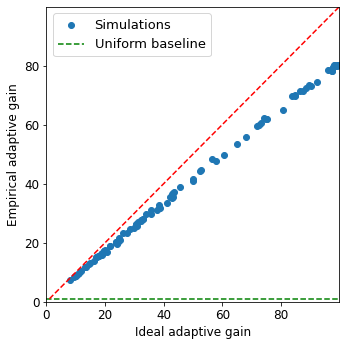

In [11]:
plt.figure(figsize=(5,5))
x = gainArr
y = unifBudgetBatch.mean(axis=1)/adaBudgetBatch.mean(axis=1)
plt.scatter(x,y, label='Simulations')
l = min(x.min(),y.min())
l = min(l,1)
h = max(x.max(),y.max())
plt.axhline(1,color='g', linestyle='--',label='Uniform baseline')
plt.plot([l,h],[l,h],'--r')
plt.rc('font', size=13)          # controls default text sizes
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

plt.tight_layout()
plt.xlim((0,h))
plt.ylim((0,h))
plt.legend()
plt.ylabel('Empirical adaptive gain')
plt.xlabel('Ideal adaptive gain')
plt.tight_layout()
# plt.savefig('figures/gainPlot_n100_l2.pdf',bbox_inches='tight',pad_inches=0.0)